In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

# =========================
# Yüz görüntüleri için geliştirme pipeline'ı
# Sıra: NLM → Bilateral → CLAHE(L) → Adaptif Gamma → Hafif Unsharp
# =========================

def read_image(path):
    """RGB döndür (BGR'den çevrilmiş)."""
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Image not found")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size)


def apply_nlmeans_denoising(img_rgb):
    """
    YCrCb tabanlı NLM: Y'de daha güçlü, Cr/Cb'de renk gürültüsünü agresif bastırır.
    """
    ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    y_d = cv2.fastNlMeansDenoising(y, None, h=10, templateWindowSize=7, searchWindowSize=21)
    cr_d = cv2.fastNlMeansDenoising(cr, None, h=12)
    cb_d = cv2.fastNlMeansDenoising(cb, None, h=12)

    merged = cv2.merge([y_d, cr_d, cb_d])
    return cv2.cvtColor(merged, cv2.COLOR_YCrCb2RGB)


def apply_bilateral(img_rgb):
    """
    Bilateral: Uzamsal + ton yakınlığıyla yumuşatır; yüz kenarlarını (burun,
    göz kapağı, dudak çizgisi) korurken renk gürültüsünü azaltır.
    """
    filtered = cv2.bilateralFilter(img_rgb, d=9, sigmaColor=50, sigmaSpace=7)
    return np.clip(filtered, 0, 255).astype(np.uint8)


def apply_clahe_on_L(img_rgb):
    """CLAHE yalnızca L kanalında; önce mikro blur ile patlamayı azaltır."""
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Mikro blur: gürültü patlamasını ve taneli görünümü azaltır
    l = cv2.GaussianBlur(l, (3, 3), 0.5)

    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge([l_eq, a, b])
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)


def apply_adaptive_gamma(img_rgb, eps=1e-6):
    """
    Ortalama parlaklığa göre gamma: loş yüzlerde açar, aşırı parlaklarda sıkıştırır.
    Aralık 0.7–1.6 tutulur ki doğal görünüm bozulmasın.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    mean = gray.mean() / 255.0
    gamma = 1.0
    if mean < 0.4:
        gamma = np.interp(mean, [0.0, 0.4], [1.6, 1.0])
    elif mean > 0.6:
        gamma = np.interp(mean, [0.6, 1.0], [1.0, 0.7])
    inv_gamma = 1.0 / max(gamma, eps)
    lut = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype(
        "uint8"
    )
    return cv2.LUT(img_rgb, lut)


def apply_edge_aware_unsharp(img_rgb, amount=0.35, sigma=1.0):
    """
    Kenar maskesiyle sadece kenarlarda hafif unsharp; gürültü geri gelmez.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 80, 150)
    edges = cv2.dilate(edges, None)

    blur = cv2.GaussianBlur(img_rgb, (0, 0), sigma)
    sharp = cv2.addWeighted(img_rgb, 1 + amount, blur, -amount, 0)

    mask = edges[..., None] / 255.0
    result = img_rgb * (1 - mask) + sharp * mask
    return np.clip(result, 0, 255).astype(np.uint8)


def professional_pipeline(img_rgb):
    """
    Bilinçli sıra:
    1) YCrCb NLM → ana gürültü temizliği, renk gürültüsü baskılanır.
    2) Bilateral → kenar korumalı yumuşatma, renk gürültüsüne ek azaltım.
    3) CLAHE (L, mikro blur sonrası) → renk kaydırmadan lokal kontrast artışı.
    4) Adaptif gamma → genel parlaklık dengesi (loş/aydınlık yüzler).
    5) Kenar-korumalı hafif unsharp → hat belirginleşir, gürültü geri gelmez.

    Kullanılmayanlar: FFT/Gabor (doğal olmayan bant vurgusu, renk artefaktı),
    adaptif eşikleme/binarizasyon (posterizasyon, detay kaybı). Amaç doğal yüz.
    """
    img = apply_nlmeans_denoising(img_rgb)
    img = apply_bilateral(img)
    img = apply_clahe_on_L(img)
    img = apply_adaptive_gamma(img)
    img = apply_edge_aware_unsharp(img)
    return np.clip(img, 0, 255).astype(np.uint8)


def preprocess_pipeline(path):
    """Tam işlem: Oku → Resize → NLM → Bilateral → CLAHE(L) → Gamma → Unsharp."""
    img = read_image(path)
    img = resize_image(img)
    return professional_pipeline(img)


In [2]:
# -------------------------
# TEST: Tek Görüntü (ÖNCE-SONRA)
# -------------------------

def test_single_image(path):
    """
    Önce-sonra karşılaştırması
    """
    # Orijinal
    original = cv2.imread(path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # İşlenmiş
    processed = preprocess_pipeline(path)
    
    # ✅ Güvenli format
    processed = np.clip(processed, 0, 255).astype(np.uint8)
    
    # Görselleştir
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(processed)
    axes[1].set_title("Processed", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return processed


In [3]:
# -------------------------
# TOPLU İŞLEM (Doğru format ile kaydet)
# -------------------------

def process_all_images(input_dir, output_dir):
    """
    Tüm görüntüleri işler ve doğru formatta kaydeder
    """
    os.makedirs(output_dir, exist_ok=True)

    # Tüm görüntüleri bul
    image_paths = glob(os.path.join(input_dir, "*.jpg"))
    image_paths += glob(os.path.join(input_dir, "*.jpeg"))
    image_paths += glob(os.path.join(input_dir, "*.png"))

    print(f"✅ {len(image_paths)} görüntü bulundu.")

    for img_path in image_paths:
        img_name = os.path.basename(img_path)

        # Pipeline uygula
        processed = preprocess_pipeline(img_path)
        
        # ✅ KRİTİK: uint8'e çevir ve RGB'den BGR'ye
        processed = np.clip(processed, 0, 255).astype(np.uint8)
        processed_bgr = cv2.cvtColor(processed, cv2.COLOR_RGB2BGR)

        # Kaydet
        save_path = os.path.join(output_dir, img_name)
        cv2.imwrite(save_path, processed_bgr)
        
        print(f"✅ {img_name} kaydedildi")


📸 TEK GÖRÜNTÜ TESTİ


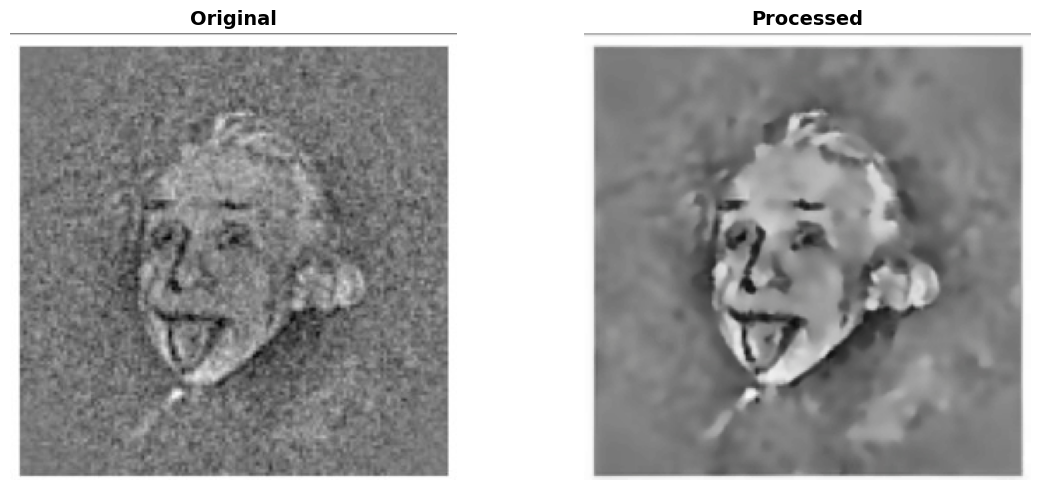

✅ Test tamamlandı

📁 TOPLU İŞLEM
✅ 10 görüntü bulundu.
✅ face1.jpg kaydedildi
✅ face10.jpg kaydedildi
✅ face3.jpg kaydedildi
✅ face4.jpg kaydedildi
✅ face5.jpg kaydedildi
✅ face6.jpg kaydedildi
✅ face7.jpg kaydedildi
✅ face2.jpeg kaydedildi
✅ face8.jpeg kaydedildi
✅ face9.jpeg kaydedildi

✅ Tüm işlemler tamamlandı!


In [4]:
# =============================================
# 📋 KULLANIM ÖRNEKLERİ
# =============================================

# 🔹 Örnek 1: Tek görüntü testi (ÖNCE-SONRA)
print("=" * 60)
print("📸 TEK GÖRÜNTÜ TESTİ")
print("=" * 60)

test_image_path = "imagesforip/face1.jpg"

if os.path.exists(test_image_path):
    result = test_single_image(test_image_path)
    print(f"✅ Test tamamlandı")
else:
    print(f"⚠️ Dosya bulunamadı: {test_image_path}")

# 🔹 Örnek 2: Tüm görüntüleri toplu işle
print("\n" + "=" * 60)
print("📁 TOPLU İŞLEM")
print("=" * 60)

process_all_images("imagesforip", "processed_outputs")

print("\n✅ Tüm işlemler tamamlandı!")
